In [1]:
import local_models.local_models
import local_models.algorithms
import local_models.utils
import local_models.linear_projections
import local_models.loggin
import local_models.TLS_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import mayavi
import mayavi.mlab
import string
import subprocess
import functools
import cv2
import itertools

#on headless systems, tmux: "Xvfb :1 -screen 0 1280x1024x24 -auth localhost", then "export DISPLAY=:1" in the jupyter tmux
mayavi.mlab.options.offscreen = True



logger = logging.getLogger(__name__)

#reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [3]:
FRESH=True

In [4]:
kernel_names = {
    local_models.local_models.GaussianKernel: 'gaussian',
    local_models.local_models.TriCubeKernel: 'tricube'
}

In [5]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [6]:
data_file = "/home/brown/Downloads/subject001/3d/andreadm2.stl"

In [7]:
import stl

tri_mesh = stl.mesh.Mesh.from_file(data_file).points.reshape(-1,3)

In [8]:
tri_mesh.shape

(346758, 3)

In [9]:
data, cts = np.unique(tri_mesh, axis=0, return_counts=True)

In [10]:
data.shape

(58659, 3)

In [11]:
(data.shape[0]*100)**(1/3)

180.348091843

In [12]:
np.mean(data, axis=0)

array([ -71.71989 , -340.46124 ,   31.036196], dtype=float32)

In [13]:
KERNEL=local_models.local_models.TriCubeKernel
RUN = 1

project_dir = "../data/np_quadrics_{}_{:03d}".format(kernel_names[KERNEL], RUN)

os.makedirs(project_dir, exist_ok=1)

In [14]:
A = np.array([[0,0,0,1]]).T
ORIGIN = np.array([[0,0,0]])
ONE = np.array([[1]])

import quadrics_utils

def diagonalize_quadric_and_translate(Q,X):
    Q_s = Q[:-1,:-1]
    _, U = np.linalg.eig(Q_s)
    UTQs = U.T@Q_s
    UL = np.diag(UTQs@U)
    #UR = UTQs@X.T + U.T@Q[:-1,-1:]
    UR = X@UTQs.T + Q[-1:,:-1]@U
    BR = np.einsum('kj,kj->k', X@Q_s, X).reshape(-1,1) + 2*X@Q[:-1,-1:] + Q[-1,-1]
    return (U, UL, UR, BR)

def array_roots(coeffses):
    ret = np.zeros((coeffses.shape[0], coeffses.shape[1]-1), dtype=complex)
    for i, coeffs in enumerate(coeffses):
        nproots = np.roots(coeffs.flatten())
        ret[i] = nproots
    return ret

projection_funcs = {
    "k_mat": quadrics_utils.k_mat,
    "other_dims_as_x": lambda a,b,c,d,e,f,g,x: [quadrics_utils.y_as_x(a,b,c,d,e,f,g,x), quadrics_utils.z_as_x(a,b,c,d,e,f,g,x)],
}
def orthogonal_quadric_project_x(X,Q,projection_funcs):
    U, ul, ur, br = diagonalize_quadric_and_translate(Q,X)
    #put all of the dimensions right for math stuff
    ul = np.tile(ul.reshape(1,-1), (X.shape[0], 1))
    args = (
        list(ul.T[...,np.newaxis]) +
        [br] +
        list(ur.T[...,np.newaxis])
    )
    
    coeffses = projection_funcs["k_mat"](*args)
    coeffses = np.stack(coeffses, axis=1)

    x = np.ma.array(array_roots(coeffses))
    return U,args,x
    
def orthogonal_quadric_projection(X,Q,projection_funcs):
    U, args, x = orthogonal_quadric_project_x(X,Q,projection_funcs)

    candidates = x.imag == 0
    x.mask = ~candidates
    other_dims = projection_funcs["other_dims_as_x"](*(args + [x]))

    pts = np.ma.stack([x] + other_dims, axis=1)
    dists = np.sum(pts**2, axis=1)
    mindists = np.argmin(dists, axis=1)
    X_indices = np.arange(X.shape[0])
    best_pts = np.array(pts[X_indices,:,mindists], dtype=float)
    best_dists = np.array(dists[X_indices,mindists],dtype=float)
    return unrotate_and_translate(U, X, best_pts), best_dists

def unrotate_and_translate(U, orig_X, new_X):
    return new_X@U.T + orig_X
    #return np.einsum('ji,ki->kj',U,orig_X) + new_X


In [15]:
def test_diagonalize_quadratic_and_translate():
    q = np.array([ # an ellipse
        [0.5,0,0,0],
        [0,0.4,0,0],
        [0,0,0.3,0],
        [0,0,0,-1],
    ])
    x = np.random.uniform(size=12).reshape(4,3)
    #x = np.ones(3).reshape(1,-1)*0.01
    #x[0,2] = 1
    
    _, ul, ur, br = diagonalize_quadric_and_translate(q,x)
    print(ul.shape,ur.shape,br.shape)
    
    q1 = np.block([[np.diag(ul), ur[:1].T],[ur[:1], br[:1]]])
    
    _,U = np.linalg.eig(q[:3,:3])
    E = np.block([[U, x[:1].T],[ORIGIN, 1]])
    q2 = E.T@q@E
    
    assert np.allclose(q1,q2)
    return x,ul,ur,br
x,ul,ur,br = test_diagonalize_quadratic_and_translate()

(3,) (4, 3) (4, 1)


In [16]:
x

array([[0.0619404 , 0.70002244, 0.37283088],
       [0.72876962, 0.26031804, 0.79020342],
       [0.10712523, 0.10682334, 0.01939804],
       [0.70480969, 0.26807666, 0.73614336]])

In [17]:
ur.shape, br.shape, ul.shape

((4, 3), (4, 1), (3,))

In [18]:
#q = np.random.uniform(size=(4,4))
#q += q.T
q = np.array([ # an ellipse
    [0.5,0,0,0],
    [0,0.25,0,0],
    [0,0,0.125,0],
    [0,0,0,-1],
])
q = np.array([ # an elliptic paraboloid
    [0.5,0,0,0],
    [0,0.25,0,0],
    [0,0,0,-1],
    [0,0,-1,0.1],
])
init_q = q
u = np.random.uniform(size=(3,3))
u += u.T
_, u = np.linalg.eig(u)
print(u)
print(np.linalg.norm(u, axis=0))
E = np.block([[u, np.zeros((3,1))],[np.zeros(3), 1]])
q = E.T@q@E
print(q)
x = np.random.uniform(size=3).reshape(1,-1)
x = np.ones(3).reshape(1,-1)*0.01
x[0,2] = 1

q

[[-0.67767991 -0.53064411 -0.50908424]
 [-0.66897615  0.73232087  0.12718904]
 [-0.3053209  -0.42675867  0.8512674 ]]
[1. 1. 1.]
[[ 0.3415073   0.05732713  0.15122647  0.3053209 ]
 [ 0.05732713  0.27486505  0.15835707  0.42675867]
 [ 0.15122647  0.15835707  0.13362765 -0.8512674 ]
 [ 0.3053209   0.42675867 -0.8512674   0.1       ]]


array([[ 0.3415073 ,  0.05732713,  0.15122647,  0.3053209 ],
       [ 0.05732713,  0.27486505,  0.15835707,  0.42675867],
       [ 0.15122647,  0.15835707,  0.13362765, -0.8512674 ],
       [ 0.3053209 ,  0.42675867, -0.8512674 ,  0.1       ]])

In [19]:
q[:3,3:]

array([[ 0.3053209 ],
       [ 0.42675867],
       [-0.8512674 ]])

In [20]:
_, ul, ur, br = diagonalize_quadric_and_translate(q,x)

In [21]:
br

array([[-1.44800079]])

In [22]:
x

array([[0.01, 0.01, 1.  ]])

In [23]:
Q1 = np.block([[np.diag(ul), ur.T],[ur, br]])
Q1

array([[ 5.00000000e-01,  0.00000000e+00,  0.00000000e+00,
        -2.60583741e-01],
       [ 0.00000000e+00,  2.50000000e-01,  0.00000000e+00,
         3.19556216e-02],
       [ 0.00000000e+00,  0.00000000e+00,  3.30812673e-18,
        -1.00000000e+00],
       [-2.60583741e-01,  3.19556216e-02, -1.00000000e+00,
        -1.44800079e+00]])

In [24]:
_,U = np.linalg.eig(q[:3,:3])

In [25]:
E = np.block([[U, x.T],[ORIGIN, 1]])
E

array([[-0.67767991, -0.66897615, -0.3053209 ,  0.01      ],
       [-0.53064411,  0.73232087, -0.42675867,  0.01      ],
       [-0.50908424,  0.12718904,  0.8512674 ,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [26]:
q

array([[ 0.3415073 ,  0.05732713,  0.15122647,  0.3053209 ],
       [ 0.05732713,  0.27486505,  0.15835707,  0.42675867],
       [ 0.15122647,  0.15835707,  0.13362765, -0.8512674 ],
       [ 0.3053209 ,  0.42675867, -0.8512674 ,  0.1       ]])

In [27]:
np.round(E.T@q@E,3)

array([[ 0.5  ,  0.   , -0.   , -0.261],
       [ 0.   ,  0.25 ,  0.   ,  0.032],
       [-0.   ,  0.   , -0.   , -1.   ],
       [-0.261,  0.032, -1.   , -1.448]])

In [28]:
E

array([[-0.67767991, -0.66897615, -0.3053209 ,  0.01      ],
       [-0.53064411,  0.73232087, -0.42675867,  0.01      ],
       [-0.50908424,  0.12718904,  0.8512674 ,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [29]:
pts, dists = orthogonal_quadric_projection(x,q, projection_funcs)
pts2, dists2 = orthogonal_quadric_projection(x,q, projection_funcs)
print(pts2, dists2)

[[0.35759051 0.43371826 0.58121769]] [0.47573495]


In [30]:
pts, dists

(array([[0.35759051, 0.43371826, 0.58121769]]), array([0.47573495]))

In [31]:
pts2, dists2

(array([[0.35759051, 0.43371826, 0.58121769]]), array([0.47573495]))

In [32]:
dists

array([0.47573495])

In [33]:
pts.shape

(1, 3)

In [34]:
pt1 = np.ones((1,4))
pt1[:,:3] = pts
pt1

array([[0.35759051, 0.43371826, 0.58121769, 1.        ]])

In [35]:
pt1@q@pt1.T

array([[-6.10622664e-16]])

In [36]:
x.shape, q.shape

((1, 3), (4, 4))

In [37]:
x = (np.random.uniform(size=(3000,3))-0.5)*10

In [38]:
pts, dists = orthogonal_quadric_projection(x,q, projection_funcs)

In [39]:
#pts, dists = orthogonal_quadric_projection2(x,q, projection_funcs)

In [40]:
check_pts, check_dists = orthogonal_quadric_projection(np.array(pts),q, projection_funcs)

In [41]:
check_dists

array([3.34677074e-27, 3.48152994e-28, 3.80576124e-29, ...,
       8.81175093e-26, 2.18590455e-26, 1.62574557e-32])

In [42]:
print(np.max(check_dists))

30.477722498455293


In [43]:
print(pts.shape, dists.shape)

(3000, 3) (3000,)


In [45]:
pth = os.path.join(project_dir, "quadric_test.png")

data_avg = np.average(pts, axis=0)
data_std = np.std(pts, axis=0)
figure = mayavi.mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=(0,0,0), engine=None, size=(1000, 1000))
#data_nodes = plt_data(figure, x[np.random.choice(np.arange(x.shape[0]), size=40, replace=False)], data_std)
vecs = pts-x
#mayavi.mlab.quiver3d(x[:,0], x[:,1], x[:,2], vecs[:,0], vecs[:,1], vecs[:,2])
quadric_nodes = plt_grid(figure, pts, data_avg, data_std)
#ellipse_axes = plt_data(figure, np.diag(np.sqrt(1/np.diag(init_q[:3,:3])))@u, data_std*10)

normalize_view(figure, data_avg, data_std)
mayavi.mlab.savefig(pth, magnification=2)
mayavi.mlab.close(figure)

In [46]:
def imshow(pth, cv2color=cv2.IMREAD_COLOR, **kwargs):
    img = cv2.imread(pth, cv2color)
    img = trim_whiteborder(img)
    plt.imshow(img, **kwargs)
    plt.axis("off")

def trim_whiteborder(img, ratio=1.1):
    img = cv2.bitwise_not(img)
    im_sq = img**2
    sum_sq_cols = np.sum(im_sq, axis=0)
    sum_sq_rows = np.sum(im_sq, axis=1)
    if len(img.shape) > 2:
        sum_sq_cols = np.sum(sum_sq_cols, axis=1)
        sum_sq_rows = np.sum(sum_sq_rows, axis=1)
    first_nonzero_col = (sum_sq_cols!=0).argmax()
    last_nonzero_col = sum_sq_cols.shape[0] - (sum_sq_cols[::-1]!=0).argmax()
    first_nonzero_row = (sum_sq_rows!=0).argmax()
    last_nonzero_row = sum_sq_rows.shape[0] - (sum_sq_rows[::-1]!=0).argmax()
    totally_trimmed = img[first_nonzero_row:last_nonzero_row, first_nonzero_col:last_nonzero_col]
    if len(img.shape) == 2:
        just_a_little_whitespace = np.zeros((
            int(totally_trimmed.shape[0]*ratio), 
            int(totally_trimmed.shape[1]*ratio)
        ), dtype=np.uint8)
    else:
        just_a_little_whitespace = np.zeros((
            int(totally_trimmed.shape[0]*ratio), 
            int(totally_trimmed.shape[1]*ratio),
            img.shape[2]
        ), dtype=np.uint8)
    jalw_middle_section_start = ((np.array(just_a_little_whitespace.shape) - np.array(totally_trimmed.shape))/2).astype(int)
    just_a_little_whitespace[
        jalw_middle_section_start[0]:jalw_middle_section_start[0] + totally_trimmed.shape[0],
        jalw_middle_section_start[1]:jalw_middle_section_start[1] + totally_trimmed.shape[1]
    ] = totally_trimmed
    #return just_a_little_whitespace
    return cv2.bitwise_not(just_a_little_whitespace)
        

(2000, 2000, 3)
(2000,) (2000,)
126 1674 407 1884


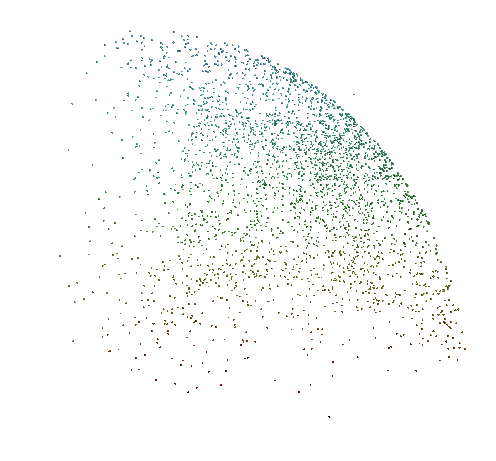

In [47]:
blah = imshow(pth)

In [50]:
def weighted_avg_and_std(values, weights=None, axis=None):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    if weights is None:
        return np.average(values, axis=axis), np.std(values, axis=axis)
    average = np.average(values, weights=weights, axis=axis)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights, axis=axis)
    return (average, np.sqrt(variance))

In [137]:
import scipy.optimize
import sklearn.utils
import sklearn.base

class QuadricModel(sklearn.base.RegressorMixin):
    def __init__(self):
        pass
    def get_params(self, *args, **kwargs):
        return dict()
    def set_params(self, params, *args, **kwargs):
        pass

    
    def _optimizer_logger(self, xk, *args):
        logging.info("quadric modeling: it{}, xk{}".format(self.i, xk))
        self.i += 1      
            
    def fit(self, X, y=None, sample_weight=None, beta0=None):
        logging.info("fitting quadric model")
        X = sklearn.utils.check_array(X)
        if beta0 is None:
            #this allows us to orient the data to set an initial set of parameters
            global_linear_model = local_models.TLS_models.LinearODR_mD(2)
            global_linear_model.fit(X, sample_weight=sample_weight)
            global_linear_vecs = global_linear_model.cov_eigenvectors[global_linear_model.cov_eigenvalues_sorter]
            global_linear_mean = global_linear_model.intercept_

            transformed_X = (X-global_linear_mean)@global_linear_vecs.T

            transformed_q = np.zeros((4,4))
            
            # an elliptic paraboloid pointing in the smallest eigenvector direction
            '''
            transformed_q[0,0] = 1/weighted_avg_and_std(transformed_X[0], weights=None)[1]**2 #flat-ish in x
            transformed_q[1,1] = 1/weighted_avg_and_std(transformed_X[1], weights=None)[1]**2 #flat-ish in y
            transformed_q[2,3] = transformed_q[3,2] = -1 # elliptic paraboloid pointing in z direction
            '''
            
            # an ellipse with axes in the various directions
            transformed_q[np.diag_indices(3)] = 1/global_linear_model.cov_eigenvalues[global_linear_model.cov_eigenvalues_sorter]**2
            transformed_q[3,3] = -1
            #print(np.diag(transformed_q), weighted_avg_and_std(transformed_X, weights = sample_weight, axis=0)[1])
            
            #print(transformed_q)
            #print(global_linear_mean)
            E = np.block([[global_linear_vecs, global_linear_mean.reshape(-1,1)],[np.zeros(3),1]])
            Einv = np.linalg.inv(E)
            q = Einv.T@transformed_q@Einv
            print(q)
            beta0 = q[np.triu_indices(4)]
        
        beta0 /= beta0[-1]
        
        self.i = 0
        self.solution = scipy.optimize.minimize(self._loss, beta0[:-1], args=(X, sample_weight), callback=self._optimizer_logger)#, method = 'Nelder-Mead')
        self.coef_ = self.solution.x
        self.intercept_ = np.array([])
        return self
            
    def _loss(self, beta, X, sample_weight=None):
        q = np.zeros((4,4))
        beta = np.concatenate((beta, [1]))
        q[np.triu_indices(4)] = beta
        q[3,3] = 1
        q += q.T
        q[np.diag_indices(4)] /= 2
        pts, dists = orthogonal_quadric_projection(X,q,projection_funcs)

        #pts, jac, dists = orthogonal_quadric_projection_with_jacobian(X,q,projection_funcs)
        
        if sample_weight is not None:
            dists *= sample_weight
        lost = np.sum(dists)
        #total_jac = np.einsum('ki,kij->ij', (X - pts), jac)
        #if lost > 20:
        #    print(q)
        #print(lost)
        return lost#, total_jac

In [ ]:
qm = QuadricModel()
qm.fit(pts)#, beta0=q[np.triu_indices(4)]+0.001)

[[ 0.27681249  0.04017082  0.17097849 -0.4425093 ]
 [ 0.04017082  0.06775505  0.04492783 -0.03859162]
 [ 0.17097849  0.04492783  0.17887278 -0.3294389 ]
 [-0.4425093  -0.03859162 -0.3294389  -0.21978061]]


In [3982]:
qm.solution

      fun: 1.6549110924078896
 hess_inv: array([[ 4.62085809e+10,  4.95199660e+10, -2.89563950e+10,
        -1.60618353e+11,  1.01727748e+11,  2.12873965e+10,
         1.08951819e+11,  3.88933132e+10, -1.45872819e+11],
       [ 4.95199654e+10,  5.30686500e+10, -3.10314590e+10,
        -1.72128534e+11,  1.09017729e+11,  2.28128871e+10,
         1.16759490e+11,  4.16804734e+10, -1.56326310e+11],
       [-2.89563947e+10, -3.10314590e+10,  1.81453918e+10,
         1.00650752e+11, -6.37472252e+10, -1.33396491e+10,
        -6.82741564e+10, -2.43723158e+10,  9.14105312e+10],
       [-1.60618352e+11, -1.72128535e+11,  1.00650753e+11,
         5.58300095e+11, -3.53599761e+11, -7.39937577e+10,
        -3.78710215e+11, -1.35190905e+11,  5.07045473e+11],
       [ 1.01727745e+11,  1.09017728e+11, -6.37472246e+10,
        -3.53599757e+11,  2.23952656e+11,  4.68639983e+10,
         2.39856380e+11,  8.56232542e+10, -3.21137605e+11],
       [ 2.12873960e+10,  2.28128869e+10, -1.33396490e+10,
        -7

In [3983]:
qq = np.zeros((4,4))
qq[np.triu_indices(4)] = np.concatenate((qm.coef_, [1]))
qq += qq.T
qq[np.diag_indices(4)] /= 2
np.round(qq,3)

array([[-1.4346903e+04, -1.5375355e+04,  8.9906930e+03,  4.9869125e+04],
       [-1.5375355e+04, -3.1585036e+04, -6.6095440e+03, -3.3827876e+04],
       [ 8.9906930e+03, -6.6095440e+03, -1.2075694e+04,  4.5290978e+04],
       [ 4.9869125e+04, -3.3827876e+04,  4.5290978e+04,  1.0000000e+00]])

In [3984]:
q

array([[ 0.19991037,  0.1817657 , -0.09489533, -0.67572345],
       [ 0.1817657 ,  0.38892396,  0.07487268,  0.43093912],
       [-0.09489533,  0.07487268,  0.16116567, -0.59807132],
       [-0.67572345,  0.43093912, -0.59807132,  0.1       ]])

In [3985]:
q

array([[ 0.19991037,  0.1817657 , -0.09489533, -0.67572345],
       [ 0.1817657 ,  0.38892396,  0.07487268,  0.43093912],
       [-0.09489533,  0.07487268,  0.16116567, -0.59807132],
       [-0.67572345,  0.43093912, -0.59807132,  0.1       ]])

In [3986]:
qq.shape

(4, 4)

In [3987]:
q.shape

(4, 4)

In [3988]:
np.array(pts)

array([[ 0.36155235,  1.23129588,  1.85642789],
       [-0.13218691,  0.97221512,  4.26794374],
       [ 0.7647154 , -6.10832972,  4.31310786],
       ...,
       [ 2.83708582, -4.24921199, -1.22549308],
       [ 2.57444886,  0.44583598, -0.68037878],
       [ 3.07029248,  0.91037167, -0.02536896]])

In [3991]:
qfit_pth = os.path.join(project_dir, "qfit_test.png")
qfit_pts, qfit_dists = orthogonal_quadric_projection(x,qq,projection_funcs)

data_avg = np.average(qfit_pts, axis=0)
data_std = np.std(qfit_pts, axis=0)
figure = mayavi.mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=(0,0,0), engine=None, size=(1000, 1000))
#data_nodes = plt_data(figure, x[np.random.choice(np.arange(x.shape[0]), size=40, replace=False)], data_std)
vecs = qfit_pts-pts
#mayavi.mlab.quiver3d(x[:,0], x[:,1], x[:,2], vecs[:,0], vecs[:,1], vecs[:,2])
quadric_nodes = plt_grid(figure, qfit_pts, data_avg, data_std)
#other_nodes = plt_grid(figure, pts, data_avg, data_std)

normalize_view(figure, data_avg, data_std)
mayavi.mlab.savefig(qfit_pth, magnification=2)
mayavi.mlab.close(figure)


(2000, 2000, 3)
(2000,) (2000,)
639 1678 541 2000


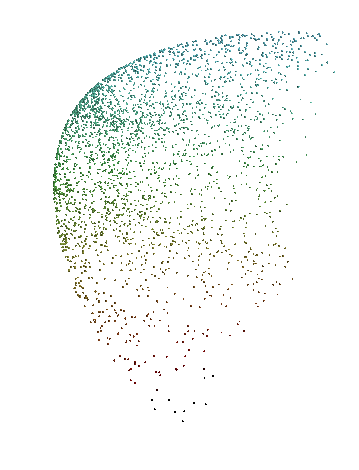

In [3992]:
imshow(qfit_pth)

In [ ]:
local_quadrics = local_models.local_models.LocalModels(QuadricModel())
local_quadrics.fit(pts)

In [ ]:
avg_pt_dist = np.average(local_quadrics.index.query(pts, k=2)[0][:,1])

In [ ]:
bandwidth = avg_pt_dist*8
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)

In [ ]:
fitted_local_quadrics, local_quadric_params = local_quadrics.transform(pts,
    r=lm_kernel.support_radius()-1, weighted=True, kernel=lm_kernel,
    neighbor_beta0s=False, batch_size=int(data.shape[0]/32), return_models=True)

NameError: name 'fitted_local_quadrics' is not defined

In [60]:
linear_models = local_models.local_models.LocalModels(local_models.TLS_models.LinearODR_mD(2))
linear_models.fit(data)

In [61]:
avg_pt_dist = np.average(linear_models.index.query(data, k=2)[0][:,1])

In [62]:
avg_pt_dist

1.2836044940342985

In [63]:
random_data_subset = data[np.random.randint(data.shape[0], size=50)]

In [64]:
queried = linear_models.index.query_radius(random_data_subset, r=avg_pt_dist*10)

In [65]:
list(map(lambda x: x.shape, queried))

[(289,),
 (315,),
 (283,),
 (386,),
 (209,),
 (106,),
 (375,),
 (321,),
 (405,),
 (372,),
 (341,),
 (352,),
 (376,),
 (308,),
 (249,),
 (347,),
 (245,),
 (380,),
 (378,),
 (414,),
 (419,),
 (106,),
 (345,),
 (320,),
 (444,),
 (282,),
 (208,),
 (371,),
 (368,),
 (423,),
 (307,),
 (435,),
 (374,),
 (324,),
 (271,),
 (147,),
 (150,),
 (147,),
 (397,),
 (318,),
 (407,),
 (200,),
 (239,),
 (403,),
 (401,),
 (316,),
 (353,),
 (321,),
 (261,),
 (289,)]

In [66]:
kernel = local_models.local_models.TriCubeKernel(bandwidth=avg_pt_dist*10)

In [67]:
linear_params_vecs, linear_params_mean = local_models.linear_projections.transformate_data(data, kernel, linear_models, r=kernel.support_radius())

In [68]:
linear_params_vecs.shape

(58659, 2, 3)

In [103]:
def imshow(pth, cv2color=cv2.IMREAD_COLOR, **kwargs):
    img = cv2.imread(pth, cv2color)
    plt.imshow(img, **kwargs)

In [83]:
N = int(data.shape[0]/10)
sample_indices = np.random.choice(np.arange(data.shape[0]), size=N)

pth = os.path.join(project_dir, "single_convergence.png")
data_avg = np.average(data, axis=0)
data_std = np.std(data, axis=0)
figure = mayavi.mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=(0,0,0), engine=None, size=(1000, 500))
data_nodes = plt_data(figure, linear_params_mean[sample_indices], data_std)
normals = np.cross(*np.rollaxis(linear_params_vecs[sample_indices],1))
#normal_vecs = plt_normals(figure, normals, linear_params_mean[sample_indices], data_std)
#neg_normal_vecs = plt_normals(figure, -normals, linear_params_mean[sample_indices], data_std)
normalize_view(figure, data_avg, data_std, azimuth=40, elevation=80)
mayavi.mlab.savefig(pth, magnification=2)
mayavi.mlab.close(figure)

(-0.5, 1999.5, 999.5, -0.5)

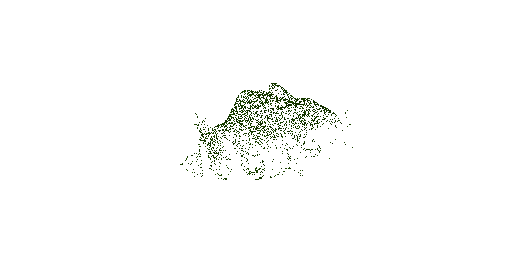

In [105]:
imshow(pth)
plt.axis("off")

In [84]:
global_linear_model = local_models.TLS_models.LinearODR_mD(2)
global_linear_model.fit(data)

In [87]:
global_linear_model.coef_
global_params_vecs = global_linear_model.coef_.reshape(2,-1)
global_params_mean = global_linear_model.intercept_
global_normal = np.cross(*global_params_vecs)

In [94]:
basis_changer = np.concatenate((global_params_vecs, global_normal.reshape(1,-1)),axis=0).T
basis_changer = np.linalg.inv(basis_changer)

In [95]:
bases_changed = np.einsum('ij,kj->ki', basis_changer, data-global_params_mean)

In [98]:
x,y,z = bases_changed.T

(-187.9690848273605,
 160.5978956286218,
 -131.18478754473625,
 174.82998666860883)

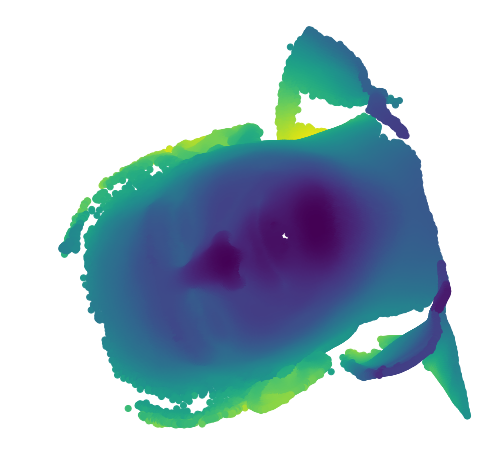

In [106]:
plt.scatter(x,y,c=z)
plt.axis("off")